In [123]:
import os, sys
import pickle

In [121]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import collections
import random
import math
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import copy

%matplotlib inline

In [122]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon

In [4]:
def divergence_from_uniform(obs, num_last_samples, num_ent):
    obs = np.array(obs)[-num_last_samples:]
    
    freqs = np.zeros(num_ent)
    u1 = np.unique(obs, return_counts=True)
    
    u1 = list(u1)
    choose1 = u1[0]!=-1
    u1[0] = u1[0][choose1]
    u1[1] = u1[1][choose1]
    
    for r in range(len(u1[0])):
        freqs[int(u1[0][r])] = u1[1][r]
    if np.sum(freqs)==0:
        return None
    
    
    rates = freqs/np.sum(freqs)
    rates_uniform = [1/num_ent]*num_ent
    return jensenshannon(freqs,rates_uniform)

In [5]:
def js_div(talk1, talk2, num_last_samples=None, num_ent=4):
    if num_last_samples:
        talk1 = np.array(talk1)[-num_last_samples:]
        talk2 = np.array(talk2)[-num_last_samples:]
    
    freqs1 = np.zeros(num_ent)
    freqs2 = np.zeros(num_ent)
    
    u1 = np.unique(talk1, return_counts=True)
    
    u1 = list(u1)
    choose1 = u1[0]!=-1
    u1[0] = u1[0][choose1]
    u1[1] = u1[1][choose1]
    
    for r in range(len(u1[0])):
        freqs1[int(u1[0][r])] = u1[1][r]
    if np.sum(freqs1)==0:
        return None
    
    rates1 = freqs1/np.sum(freqs1)
    
    u2 = np.unique(talk2, return_counts=True)
    
    u2 = list(u2)
    choose2 = u2[0]!=-1
    u2[0] = u2[0][choose2]
    u2[1] = u2[1][choose2]
    
    for r in range(len(u2[0])):
        freqs2[int(u2[0][r])] = u2[1][r]
    if np.sum(freqs2)==0:
        return None
    rates2 = freqs2/np.sum(freqs2)
    
    return jensenshannon(rates1, rates2)

In [6]:
def kl_divergence(talk1, talk2, num_last_samples=None, num_ent=4):
    if num_last_samples:
        talk1 = np.array(talk1)[-num_last_samples:]
        talk2 = np.array(talk2)[-num_last_samples:]
    
    freqs1 = np.zeros(num_ent)
    freqs2 = np.zeros(num_ent)
    
    u1 = np.unique(talk1, return_counts=True)
    
    u1 = list(u1)
    choose1 = u1[0]!=-1
    u1[0] = u1[0][choose1]
    u1[1] = u1[1][choose1]
    
    for r in range(len(u1[0])):
        freqs1[int(u1[0][r])] = u1[1][r]
    rates1 = freqs1/np.sum(freqs1)
    
    u2 = np.unique(talk2, return_counts=True)
    
    u2 = list(u2)
    choose2 = u2[0]!=-1
    u2[0] = u2[0][choose2]
    u2[1] = u2[1][choose2]
    
    for r in range(len(u2[0])):
        freqs2[int(u2[0][r])] = u2[1][r]
    rates2 = freqs2/np.sum(freqs2)
    
    return entropy(rates1, rates2)

In [7]:
def speaker_consistency(a_talk, a_act, num_last_samples):
    a_act = np.array(a_act)
    a_talk = np.array(a_talk)
    choice = a_talk[-num_last_samples:]!=-1
    a_talk = a_talk[-num_last_samples:][choice] 
    a_act = a_act[-num_last_samples:][choice]
    return normalized_mutual_info_score(a_talk, a_act, average_method='arithmetic')

In [8]:
def listener_consistency(a_talk, a2_act, num_last_samples):
    a2_act = np.array(a2_act)
    a_talk = np.array(a_talk)
    choice = a_talk[-num_last_samples:]!=-1
    a_talk = a_talk[-num_last_samples:][choice] 
    a2_act = a2_act[-num_last_samples:][choice]
    return normalized_mutual_info_score(a_talk, a2_act, average_method='arithmetic')

In [9]:
def sl_consistencies(games, cond_list_num_agents, num_last_samples, two_agent_game): 
    sc_list = []
    lc_list = []
    if two_agent_game:
        for i in range(len(cond_list_num_agents)):
            sc = np.mean([speaker_consistency(games[i][0][0], games[i][1][0], num_last_samples), speaker_consistency(games[i][0][1], games[i][1][1], num_last_samples)])
            lc = np.mean([listener_consistency(games[i][0][0], games[i][1][1], num_last_samples), listener_consistency(games[i][0][1], games[i][1][0], num_last_samples)])
            sc_list.append(sc)
            lc_list.append(lc)
    else:        
        for i in range(len(cond_list_num_agents)):
            sc_cond = []
            lc_cond = []
            for n in range(cond_list_num_agents[i]):
                for j in range(n+1, cond_list_num_agents[i]):
                    #select only the games of these 2 players
                    games_choice_for_j = np.logical_or(np.sum(np.array(games[i][3])==[n,j],axis=1)==2,np.sum(np.array(games[i][3])==[j,n],axis=1)==2)[np.sum(np.array(games[i][3])==j, axis=1)>0]
                    games_choice_for_n = np.logical_or(np.sum(np.array(games[i][3])==[n,j],axis=1)==2,np.sum(np.array(games[i][3])==[j,n],axis=1)==2)[np.sum(np.array(games[i][3])==n, axis=1)>0]            
                    sc = np.mean([speaker_consistency(np.array(games[i][0][n])[games_choice_for_n], np.array(games[i][1][n])[games_choice_for_n], num_last_samples), speaker_consistency(np.array(games[i][0][j])[games_choice_for_j], np.array(games[i][1][j])[games_choice_for_j], num_last_samples)])
                    lc = np.mean([listener_consistency(np.array(games[i][0][n])[games_choice_for_n], np.array(games[i][1][j])[games_choice_for_j], num_last_samples), listener_consistency(np.array(games[i][0][j])[games_choice_for_j], np.array(games[i][1][n])[games_choice_for_n], num_last_samples)])
                    sc_cond.append(sc)
                    lc_cond.append(lc)
            sc_list.append(np.mean(sc_cond))
            lc_list.append(np.mean(lc_cond))
    return (sc_list, lc_list)

In [10]:
def action_talk_js_uniform(games, cond_list_num_agents, num_last_samples, n_ent_vector = []):
    action_div_list = []
    talk_div_list = []
    if len(n_ent_vector) == 0:
        n_ent_vector = [4]*len(cond_list_num_agents)
    for i in range(len(cond_list_num_agents)):
        ad_cond = []
        td_cond = []
        for n in range(cond_list_num_agents[i]):
            #select only the games of this player
            # TODO
            ad = divergence_from_uniform(np.array(games[i][1][n]), num_last_samples, n_ent_vector[i])
            td = divergence_from_uniform(np.array(games[i][0][n]), num_last_samples, n_ent_vector[i])
            ad_cond.append(ad)
            td_cond.append(td)
        action_div_list.append(np.mean(ad_cond))
        talk_div_list.append(np.mean(td_cond))
    return(action_div_list, talk_div_list)

In [145]:
def meaning_mapping(games_arr, cond_list_num_agents, num_last_samples, exp2ag=False):
    if exp2ag:
        games = games_arr
    else:
        games = games_data_vectorized(games_arr, cond_list_num_agents)
    div_list = []
    if exp2ag:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            act_agents = []
            for a in range(cond_list_num_agents[i]):
                act_agent = []
                if a ==0:
                    other_a = 1
                elif a==1:
                    other_a = 0
                for k in range(4): # here should be vocabulary size
                        #for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                        #for_counting = for_counting[:,-num_last_samples:]
                    choose = np.logical_or(np.logical_and(games[i][0][a][-num_last_samples:]!=-1,games[i][1][a][-num_last_samples:]==k),np.logical_and(games[i][0][a][-num_last_samples:]==-1,games[i][1][other_a][-num_last_samples:]==k))
                    actions = games[i][1][a][-num_last_samples:][choose]
                        #other_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)!=a,np.max(for_counting, axis=0)==k)]
                        #div = js_div(self_actions, other_actions, None)
                        #if div:
                        #    divs.append(div)
                    act_agent.append(actions)
                act_agents.append(act_agent)
            for m in range(cond_list_num_agents[i]):
                divs_cond = []
                for j in range(m+1, cond_list_num_agents[i]):
                    divs_ent = []
                    for n in range(4):
                        divs_ent.append(js_div(act_agents[m][n], act_agents[j][n], None))
                divs_cond.append(np.nanmean(divs_ent))
            div_list.append(np.nanmean(divs_cond))

    
    else:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            act_agents = []
            for a in range(cond_list_num_agents[i]):
                act_agent = []
                for k in range(4): # here should be vocabulary size
                    for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                    for_counting = for_counting[:,-num_last_samples:]
                    actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.max(for_counting, axis=0)==k]
                    #other_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)!=a,np.max(for_counting, axis=0)==k)]
                    #div = js_div(self_actions, other_actions, None)
                    #if div:
                    #    divs.append(div)
                    act_agent.append(actions)
                act_agents.append(act_agent)
            for m in range(cond_list_num_agents[i]):
                divs_cond = []
                for j in range(m+1, cond_list_num_agents[i]):
                    divs_ent = []
                    for n in range(4):
                        divs_ent.append(js_div(act_agents[m][n], act_agents[j][n], None))
                divs_cond.append(np.nanmean(divs_ent))

            div_list.append(np.nanmean(divs_cond))
    return div_list

In [146]:
def meaning_asymmetry(games_arr, cond_list_num_agents, num_last_samples, exp2ag=False):
    if exp2ag:
        games = games_arr
    else:
        games = games_data_vectorized(games_arr, cond_list_num_agents)
    div_list = []
    if exp2ag:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            for j in range(2):
                games[i][0][j] = np.array(games[i][0][j])
                games[i][1][j] = np.array(games[i][1][j])
            divs_agents = []
            for a in range(cond_list_num_agents[i]):
                divs = []
                if a ==0:
                    other_a = 1
                elif a==1:
                    other_a = 0
                for k in range(4): # here should be vocabulary size
                    #for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                    #for_counting = for_counting[:,-num_last_samples:]
                    self_actions = games[i][1][a][-num_last_samples:][np.logical_and(games[i][0][a][-num_last_samples:]!=-1,games[i][0][a][-num_last_samples:]==k)]
                    other_actions = games[i][1][a][-num_last_samples:][np.logical_and(games[i][0][a][-num_last_samples:]==-1,games[i][0][other_a][-num_last_samples:]==k)]
                    div = js_div(self_actions, other_actions, None)
                    if div:
                        divs.append(div)
                divs_agents.append(np.nanmean(divs))

            div_list.append(np.nanmean(divs_agents))
    else:
        for i in range(len(games)):
            games[i][0] = np.array(games[i][0])
            games[i][1] = np.array(games[i][1])
            divs_agents = []
            for a in range(cond_list_num_agents[i]):
                divs = []
                for k in range(4): # here should be vocabulary size
                    for_counting = games[i][0][:,games[i][0][a]!=-2.0]
                    for_counting = for_counting[:,-num_last_samples:]
                    self_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)==a,np.max(for_counting, axis=0)==k)]
                    other_actions = games[i][1][a][games[i][0][a]!=-2.0][-num_last_samples:][np.logical_and(np.argmax(for_counting, axis=0)!=a,np.max(for_counting, axis=0)==k)]
                    div = js_div(self_actions, other_actions, None)
                    if div:
                        divs.append(div)
                divs_agents.append(np.nanmean(divs))

            div_list.append(np.nanmean(divs_agents))
    return div_list                 
                

In [42]:
def games_data(games):
    speakers_all = []
    listeners_all = []
    talks_all = []
    actions_speaker_all = []
    actions_listener_all = []
    sim_length = len(games[1][0][0])
    rewards_all = []

    for i in range(len(games)):
        speakers = []
        listeners = []
        talks = []
        actions_speaker = []
        actions_listener = []
        rewards = []
        print(i)
        for j in range(sim_length):
            speaker = games[i][3][j][0]
            listener = games[i][3][j][1]
            choose = np.array(games[i][0][speaker])!=-1
            talk = np.array(games[i][0][speaker])[choose][speakers.count(speaker)]
            reward = games[i][3][j]
            if j>0:
                action_speaker = games[i][1][speaker][np.sum(np.sum(np.array(games[i][3][:j])== speaker, axis=1))]
                action_listener = games[i][1][listener][np.sum(np.sum(np.array(games[i][3][:j])== listener, axis=1))]
            else:
                action_speaker = games[i][1][speaker][0]
                action_listener = games[i][1][listener][0]

            speakers.append(speaker)
            listeners.append(listener)
            talks.append(talk)
            rewards.append(reward)
            actions_speaker.append(action_speaker)
            actions_listener.append(action_listener)

        speakers_all.append(speakers)
        listeners_all.append(listeners)
        talks_all.append(talks)
        actions_speaker_all.append(actions_speaker)
        actions_listener_all.append(actions_listener)
        rewards_all.append(rewards)
        
        
    return [speakers_all, listeners_all, talks_all, actions_speaker_all,
                actions_listener_all, rewards_all]



In [14]:
def games_data_vectorized(games_arr, cond_list_num_agents):
    games = games_arr.copy()
    for i in range(len(games)):
        
        for a in range(cond_list_num_agents[i]):
            choose = np.sum(np.array(games[i][-2])==a,axis=1)>0 #0 - didn't play, 1 - played in the game
            dt = np.zeros(60000)-2
            da = np.zeros(60000)-2
            dt[choose] = np.array(games[i][0][a])
            da[choose] = np.array(games[i][1][a])
            games[i][0][a] = dt
            games[i][1][a] = da
    return games
            

In [15]:
# talk rate divergence of different agents: evaluate how they partition the symbol space
def talk_divergence(games, cond_list_num_agents, num_last_samples):
    talking_div_list = []
    for i in range(len(cond_list_num_agents)):
        td_cond = []
        for n in range(cond_list_num_agents[i]):
            for j in range(n+1, cond_list_num_agents[i]):
                # jensen shannon divergence
                td1 = js_div(np.array(games[i][0][n]), np.array(games[i][0][j]), num_last_samples)
                #td2 = kl_divergence(np.array(games[i][0][j]), np.array(games[i][0][n]), num_last_samples) # the other direction
                td_cond.append(td1)
        talking_div_list.append(np.mean(td_cond))
    return talking_div_list

In [16]:
#TODO
#def communication_asymmetry(a1_talk, a2_talk, a1_act, a2_act, num_last_samples):
    # kl divergence of ag x responses when agent x talks and when ag x listens
#    a1_act = np.array(a1_act)
#    a2_act = np.array(a2_act)
#    a1_talk = np.array(a1_talk)
#    a2_talk = np.array(a2_talk)
#    choice1 = a1_talk[-num_last_samples:]!=-1
#    choice2 = a2_talk[-num_last_samples:]!=-1
#    kl_list = []
#    for i in np.unique(a1_talk): 
#        if i == -1:
#            pass
#        else:
            #a1 talks ditribution
#            a1_act_1 = a1_act[choice1][a1_talk[choice1]==i]
#            a1_act_2 = a1_act[choice2][a2_talk[choice2]==i]
            

In [17]:
# Symmetry of meanings: divergence of actions when agent speaks vs. when it listens for each talking instance
#sc_list = []
#lc_list = []
#for i in range(len(cond_list_3[0])):
#    sc_cond = []
#    lc_cond = []
#    for n in range(cond_list_3[1][i]):
#            #select only the games of these 2 players
#            games_choice_for_j = np.logical_or(np.sum(np.array(games_3[i][3])==[n,j],axis=1)==2,np.sum(np.array(games_3[i][3])==[j,n],axis=1)==2)[np.sum(np.array(games_3[i][3])==j, axis=1)>0]
#            games_choice_for_n = np.logical_or(np.sum(np.array(games_3[i][3])==[n,j],axis=1)==2,np.sum(np.array(games_3[i][3])==[j,n],axis=1)==2)[np.sum(np.array(games_3[i][3])==n, axis=1)>0]            
#            sc = np.mean([speaker_consistency(np.array(games_3[i][0][n])[games_choice_for_n], np.array(games_3[i][1][n])[games_choice_for_n], 4000), speaker_consistency(np.array(games_3[i][0][j])[games_choice_for_j], np.array(games_3[i][1][j])[games_choice_for_j], 4000)])
#            lc = np.mean([listener_consistency(np.array(games_3[i][0][n])[games_choice_for_n], np.array(games_3[i][1][j])[games_choice_for_j], 4000), listener_consistency(np.array(games_3[i][0][j])[games_choice_for_j], np.array(games_3[i][1][n])[games_choice_for_n], 4000)])
#            sc_cond.append(sc)
#            lc_cond.append(lc)
#    sc_list.append(np.mean(sc_cond))
#    lc_list.append(np.mean(lc_cond))

In [18]:
# usage: make_plots(games[i][2][0], games[i][2][1], games[i][0][0], games[i][1][0], games[i][0][1], games[i][1][1],4,4,title,50
def prep_proportion_plot(chosen_options, num_options, horizon=50):
 
  chosen_options = np.array(chosen_options)
  ohe = OneHotEncoder(categories=[np.arange(num_options)], sparse=False)
  opts_onehot = ohe.fit_transform(chosen_options.reshape(-1, 1))
 
  action_hist_proportion = np.zeros((opts_onehot.shape[0] - horizon + 1, num_options))
 
  for i in range(num_options):
    action_hist_proportion[:, i] = np.convolve(opts_onehot[:, i], np.ones((horizon,)) / horizon, mode='valid')
 
  return action_hist_proportion
 
def make_plots(scores_1, scores_2, a1_talk, a1_act, a2_talk, a2_act, num_actions, num_phrases, game_title = "", horizon=50):
    
        scores_1 = np.array(scores_1)
        scores_2 = np.array(scores_2)
        a1_talk = np.array(a1_talk)
        a1_act = np.array(a1_act)
        a2_talk = np.array(a2_talk)
        a2_act = np.array(a2_act)
        
        ## Assumes no compositionality
 
        a1_talk, a1_act, a2_act = np.array(a1_talk), np.array(a1_act), np.array(a2_act)
    
        plt.figure()
        plt.plot(np.convolve(scores_1, np.ones((100,))/100, mode='valid'))
        plt.plot(np.convolve(scores_2, np.ones((100,))/100, mode='valid'))
        plt.title("Scores" + "\n" + game_title)
               
        ## Chosen action history
 
        action_hist = prep_proportion_plot(a1_act, num_actions)
        plt.figure()
        plt.plot(action_hist)
        plt.legend(["Action {}".format(i) for i in range(num_actions)])
        plt.title("action proportions (agent 1)" + "\n" + game_title)
 
        ## Chosen action history
 
        action_hist = prep_proportion_plot(a2_act, num_actions)
        plt.figure()
        plt.plot(action_hist)
        plt.legend(["Action {}".format(i) for i in range(num_actions)])
        plt.title("action proportions (agent 2)" + "\n" + game_title)
 
        ## Chosen correct action history
 
        action_hist = prep_proportion_plot(a1_act[a1_act==a2_act], num_actions)
        plt.figure()
        plt.plot(np.arange(a1_act.shape[0])[a1_act==a2_act][:-horizon+1], action_hist)
        plt.legend(["Action {}".format(i) for i in range(4)])
        plt.title("action proportions when won" + "\n" + game_title)
 
        ## Chosen talk history
        a1_talk1 = a1_talk[a1_talk!=-1]
        talk_hist = prep_proportion_plot(a1_talk1, num_phrases)
        plt.figure()
        plt.plot(talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions (agent 1)" + "\n" + game_title)
 
        ## Chosen talk history when won
        a1_talk2 = a1_talk[a1_talk!=-1]
        a1_talk2 = a1_talk2[a1_act[a1_talk!=-1]==a2_act[a1_talk!=-1]]
        talk_hist = prep_proportion_plot(a1_talk2, num_phrases)
        plt.figure()
        plt.plot(np.arange(a1_talk2.shape[0])[:-horizon+1], talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions when won (agent 1)" + "\n" + game_title)
        
        ## Chosen talk history
        a2_talk1 = a2_talk[a2_talk!=-1]
        talk_hist = prep_proportion_plot(a2_talk1, num_phrases)
        plt.figure()
        plt.plot(talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions (agent 2)" + "\n" + game_title)
 
        ## Chosen talk history when won
        a2_talk2 = a2_talk[a2_talk!=-1]
        a2_talk2 = a2_talk2[a1_act[a2_talk!=-1]==a2_act[a2_talk!=-1]]
        talk_hist = prep_proportion_plot(a2_talk2, num_phrases)
        plt.figure()
        plt.plot(np.arange(a2_talk2.shape[0])[:-horizon+1], talk_hist)
        plt.legend(["Phrase {}".format(i) for i in range(num_phrases)])
        plt.title("Phrase proportions when won (agent 2)" + "\n" + game_title)
 
        ## Actions when specific phrase
 
        for i in range(num_phrases):
 
          plt.figure()
          act_hist = prep_proportion_plot(a1_act[a1_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a1_act.shape[0])[a1_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 1 when agent 1's message is {}".format(i) + "\n" + game_title)
 
          plt.figure()
          act_hist = prep_proportion_plot(a2_act[a1_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a2_act.shape[0])[a1_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 2 when agent 1's message is {}".format(i) + "\n" + game_title)
        
        
        for i in range(num_phrases):
 
          plt.figure()
          act_hist = prep_proportion_plot(a1_act[a2_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a1_act.shape[0])[a2_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 1 when agent 2's message is {}".format(i) + "\n" + game_title)
 
          plt.figure()
          act_hist = prep_proportion_plot(a2_act[a2_talk==i], num_actions)
          plt.figure()
          plt.plot(np.arange(a2_act.shape[0])[a2_talk==i][:-horizon+1], act_hist)
          plt.legend(["Action {}".format(i) for i in range(num_phrases)])
          plt.title("Action proportions for agent 2 when agent 2's message is {}".format(i) + "\n" + game_title)
 
### Usage
#make_plots(scores1, scores2, a1_talk, a1_act, a2, 4, 4, 50)
#make_plots(d[3][0], d[3][1], d[1][0], d[2][0], d[1][1], d[2][1], 4, 4, 50)

## Experiment 1: Inner Speech and Supervision

In [97]:
# new conditions
cond_list_2 = [[],[]]
#lrates = [0.00001,0.0001,0.001,0.01,0.1]
#punishment_weights = [3]
beta = [0.3]
memory_replay = [[10],[10]]
inner_speech_conditions = [0,1]
num_agents = [2]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 20
#for lr in lrates:
#for inn in inner_speech_conditions:
for superv in supervision:
    for inn in inner_speech_conditions:
        for j in range(samples):
                cond_list_2[0].append(superv)
                cond_list_2[1].append(inn)

In [98]:
dirs = os.listdir("lang_games_supervision_inner_speech_2_agents_2/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game38.pkl',
 'game39.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game50.pkl',
 'game51.pkl',
 'game52.pkl',
 'game53.pkl',
 'game54.pkl',
 'game55.pkl',
 'game56.pkl',
 'game57.pkl',
 'game58.pkl',
 'game59.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'gam

In [99]:
games_2 = []
for file in dirs:
    with open("lang_games_supervision_inner_speech_2_agents_2/{}".format(file), "rb") as f:
        g = pickle.load(f)
        games_2.append(g)
        # [talks, acts, scores, self_talks, self_acts, self_scores, joint_scores, samples, conds]
        # for each game, the supervision condition is games[i][-1][0], the beta is games[i][-1][1]
        # other parameters: d = play_many_games_semisupervised(2, 30000, 1, 0.0001, 3, 0, 10, 10, beta, supervision_rate)

Calculating mean scores for the last games

In [101]:
mean_scores_2 = []
for i in range(len(cond_list_2[0])):
    avg = np.mean([np.mean(games_2[i][2][0][-2000:]), np.mean(games_2[i][2][1][-2000:])])
    mean_scores_2.append(avg)

Calculating 

1) speaker and listener consistencies

2) divergence of actions and talking rates from uniform

3) divergence of agents' talk distributions 

In [102]:
n_agents=[2]*400
sc_list1, lc_list1 = sl_consistencies(games_2, n_agents, 4000, True)
ac_div1, talk_div1 = action_talk_js_uniform(games_2, n_agents, 4000)
td1 = talk_divergence(games_2, n_agents, 4000)

In [147]:
games_2_copy = copy.deepcopy(games_2)

In [148]:
#games_2_copy = copy.deepcopy(games_2)
print("copy done")
div_list_2 = meaning_asymmetry(games_2, n_agents, 4000, True)
print("meaning asymmetry calculated")
games_2_copy = copy.deepcopy(games_2)
print("copy done")
mean_map_2 = meaning_mapping(games_2_copy, n_agents, 4000, True)

copy done
meaning asymmetry calculated
copy done


In [149]:
data_2 = {"supervision rate": cond_list_2[0], "self-play": cond_list_2[1], "Score": mean_scores_2, 
         "speaker consistency": sc_list1, "listener consistency": lc_list1, 
         "action divergence from uniform": ac_div1, "talking divergence from uniform": talk_div1,
         "talking divergence": td1, "meaning divergence": div_list_2, "meaning mapping": mean_map_2}

In [150]:
df_2 = pd.DataFrame(data_2) 
df_2

,supervision rate,self-play,Score,speaker consistency,listener consistency,action divergence from uniform,talking divergence from uniform,talking divergence,meaning divergence,meaning mapping
0,0.0,0,0.42626,0.670863,0.652868,0.024535,0.159210,0.140418,0.697058,0.040610
1,0.0,0,0.56085,0.731090,0.674441,0.025572,0.280784,0.323346,0.446453,0.072413
2,0.0,0,0.49634,0.703624,0.692980,0.035496,0.276727,0.251433,0.423474,0.066499
3,0.0,0,0.49789,0.729107,0.702965,0.029590,0.205686,0.188389,0.679922,0.060753
4,0.0,0,0.51933,0.733959,0.675056,0.042251,0.263308,0.093091,0.281287,0.060149
...,...,...,...,...,...,...,...,...,...,...
395,0.9,1,0.54179,0.745563,0.732993,0.015012,0.022243,0.034243,0.053735,0.032093
396,0.9,1,0.51850,0.759289,0.723278,0.036495,0.040582,0.030163,0.046241,0.027949
397,0.9,1,0.54360,0.733776,0.714348,0.017142,0.024692,0.036270,0.041839,0.028738
398,0.9,1,0.59485,0.732101,0.739433,0.023279,0.021686,0.017245,0.037406,0.018154


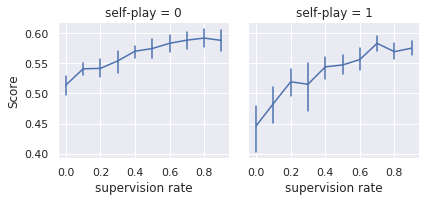

In [151]:
#plt.rc('text', usetex=False)#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

ax = sns.FacetGrid(df_2, col="self-play")
ax.map(sns.lineplot,"supervision rate", "Score", 
                  err_style="bars")
ax.add_legend()

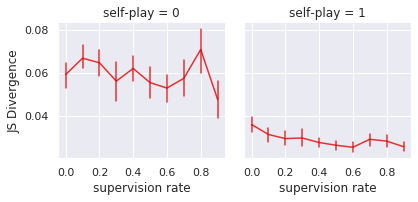

In [152]:
ax = sns.FacetGrid(df_2, col="self-play")
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["red"], label = "signal-action mapping")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence')
#plt.legend()


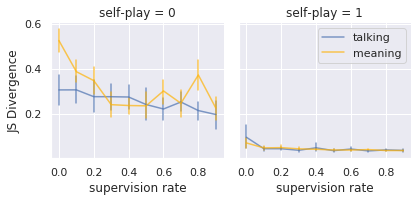

In [153]:
ax = sns.FacetGrid(df_2, col="self-play")
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars", alpha=0.7, label = "talking")
ax.map(sns.lineplot,"supervision rate", "meaning divergence", 
                  err_style="bars", alpha=0.7, color=sns.xkcd_rgb["amber"], label = "meaning")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS Divergence')
plt.legend()

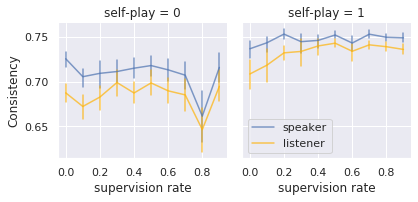

In [154]:
ax = sns.FacetGrid(df_2, col="self-play")
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha = 0.7, label = "speaker")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", color=sns.xkcd_rgb["amber"], alpha=0.7, label = "listener")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

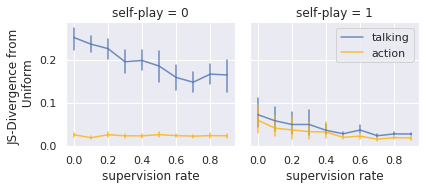

In [155]:
ax = sns.FacetGrid(df_2, col="self-play")
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars", alpha = 0.8, label = "talking")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars", color=sns.xkcd_rgb["amber"], alpha=0.8, label = "action")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS-Divergence from \n Uniform')
plt.legend()

# Experiment 2: different numbers of agents and supervision rate

In [34]:
cond_list_3 = [[],[]]
#lrates = [0.00001,0.0001,0.001,0.01,0.1]
punishment_weights = [3]
beta = [0.3]
memory_replay = [[10],[10]]
inner_speech_conditions = [0,1]
num_agents = [2,3,4,5,6]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 10
#for lr in lrates:
#for inn in inner_speech_conditions:
for superv in supervision:
    for n in num_agents:
        for j in range(samples):
            cond_list_3[0].append(superv)
            cond_list_3[1].append(n)
            
#cond_list_3 = cond_list_3[-218]

In [35]:
# one game is missing
cond_list_3[0].pop(218)
cond_list_3[1].pop(218)

3

In [36]:
dirs = os.listdir("lang_games_supervision_many_agents/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game38.pkl',
 'game39.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'game67.pkl',
 'game68.pkl',
 'game69.pkl',
 'game70.pkl',
 'game71.pkl',
 'game72.pkl',
 'game73.pkl',
 'game74.pkl',
 'game75.pkl',
 'game76.pkl',
 'gam

In [37]:
games_3 = []
for file in dirs:
    with open("lang_games_supervision_many_agents/{}".format(file), "rb") as f:
        g = pickle.load(f)
        games_3.append(g)
        # for each game, the supervision condition is games[i][-1][0], the beta is games[i][-1][1]
        # returns [talks, acts, scores, samples, conditions] 
        # other parameters: play_many_games_semisupervised(n, 60000, 0, 0.0001, 4, 0, 10, 10, 0.3, supervision_rate)

In [38]:
#check the same/different conditions 
different_idx = []
for i in range(len(cond_list_3[0])):
    if cond_list_3[1][i] == games_3[i][4][1]:
        print('true!')
    else:
        print(str(i) + "not correct " + str(cond_list_3[1][i]) + " " + str(games_3[i][4][1]))
        different_idx.append(i)
    #means = []
    #for n in range(cond_list_3[1][i]): # for each agent in the game
    #    means.append(np.mean(games_3[i][2][n][-2000:]))
    #avg = np.mean(means)
    #mean_scores_3.append(avg)
    #avg = np.mean([np.mean(games_3[i][2][0][-2000:]), np.mean(games_3[i][2][1][-2000:])])
    #mean_scores_2.append(avg)

true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true!
true

In [39]:
# remove the messed trials
subtract = 0
for i in different_idx:
    cond_list_3[0].pop(i-subtract)
    cond_list_3[1].pop(i-subtract)
    games_3.pop(i-subtract)
    subtract += 1

Calculating mean scores 

In [40]:
mean_scores_3 = []
for i in range(len(cond_list_3[0])):
    means = []
    for n in range(cond_list_3[1][i]): # for each agent in the game
        means.append(np.mean(games_3[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_3.append(avg)

Calculating 

1) speaker and listener consistencies

2) action and talk KL-Divergence from Uniform distribution

3) divergence of agents' talk distributions

4) divergence of I-talk actions and others-talk actions

5) divergence of meanings for all symbols

In [41]:
sc_list3, lc_list3 = sl_consistencies(games_3, cond_list_3[1], 4000, False)
ac_div3, talk_div3 = action_talk_js_uniform(games_3, cond_list_3[1], 4000)
td3 = talk_divergence(games_3, cond_list_3[1], 4000)

In [42]:
games_3_copy = copy.deepcopy(games_3)
div_list_3 = meaning_asymmetry(games_3_copy, cond_list_3[1], 4000)
games_3_copy = copy.deepcopy(games_3)
mean_map_3 = meaning_mapping(games_3_copy, cond_list_3[1], 4000)

In [43]:
data_3 = {"supervision rate": cond_list_3[0], "number of agents": cond_list_3[1], "score": mean_scores_3, 
         "speaker consistency": sc_list3, "listener consistency": lc_list3, 
         "action divergence from uniform": ac_div3, "talking divergence from uniform": talk_div3,
         "talking divergence": td3, "meaning divergence": div_list_3, "meaning mapping": mean_map_3}

In [45]:
df_3 = pd.DataFrame(data_3) 
df_3

,supervision rate,number of agents,score,speaker consistency,listener consistency,action divergence from uniform,talking divergence from uniform,talking divergence,meaning divergence,meaning mapping
0,0.0,2,0.526180,0.711247,0.701820,0.031705,0.236156,0.342381,0.345695,0.053234
1,0.0,2,0.520420,0.746653,0.664827,0.023181,0.276594,0.233890,0.429343,0.067986
2,0.0,2,0.482460,0.698616,0.619424,0.016288,0.353482,0.426178,0.462504,0.070301
3,0.0,2,0.479820,0.729274,0.689660,0.038856,0.216636,0.411566,0.664244,0.026507
4,0.0,2,0.525730,0.719464,0.652845,0.014453,0.349242,0.653565,0.538323,0.064050
...,...,...,...,...,...,...,...,...,...,...
491,0.9,6,0.485180,0.540290,0.530041,0.244533,0.169077,0.165554,0.083804,0.027842
492,0.9,6,0.713360,0.615552,0.598120,0.021970,0.052576,0.089417,0.046996,0.028507
493,0.9,6,0.476687,0.524162,0.515190,0.237865,0.248083,0.032815,0.092503,0.066401
494,0.9,6,0.709060,0.575237,0.554234,0.012667,0.031099,0.048895,0.040090,0.022769


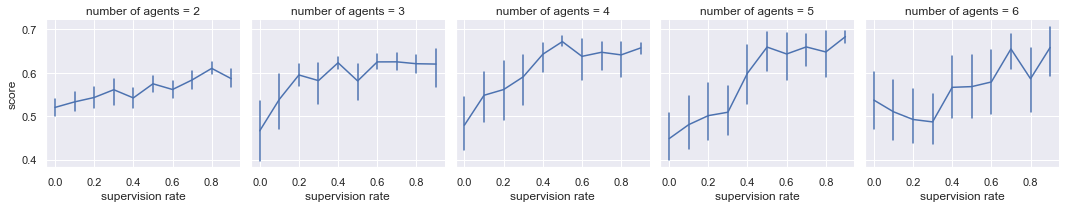

In [46]:
ax = sns.FacetGrid(df_3, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "score", 
                  err_style="bars")
ax.add_legend()

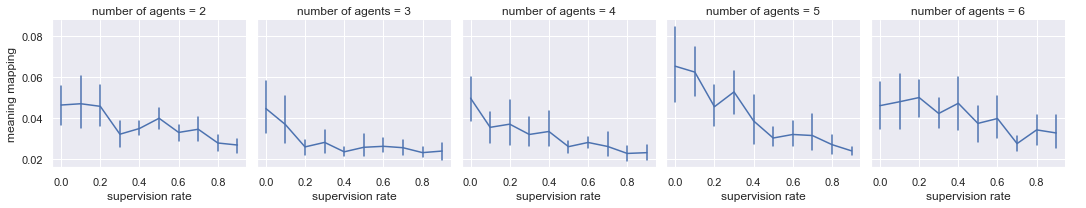

In [47]:
ax = sns.FacetGrid(df_3, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars")
ax.add_legend()

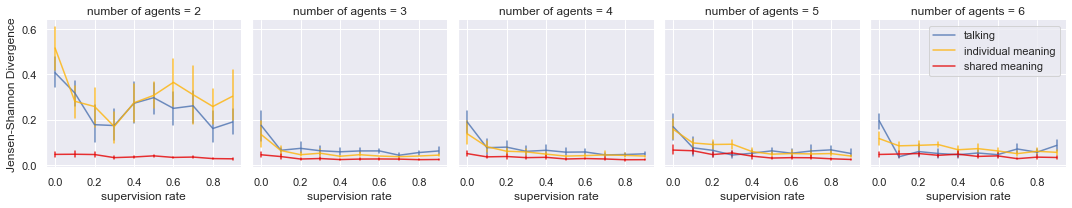

In [48]:
ax = sns.FacetGrid(df_3, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars", alpha=0.8, label = "talking")
ax.map(sns.lineplot,"supervision rate", "meaning divergence", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["amber"], label = "individual meaning")
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["red"], label = "shared meaning")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Jensen-Shannon Divergence')
plt.legend()

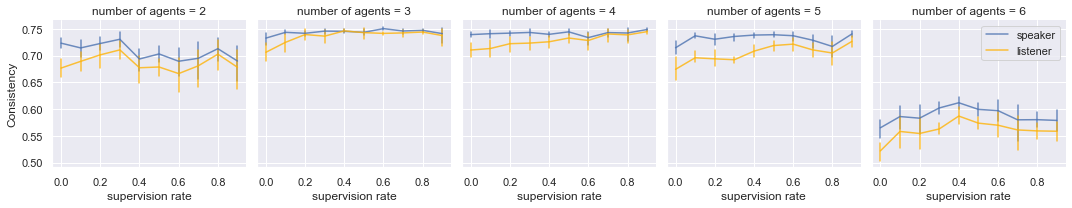

In [49]:
ax = sns.FacetGrid(df_3, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha=0.8, label = "speaker")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["amber"], label = "listener")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

#ax.add_legend()

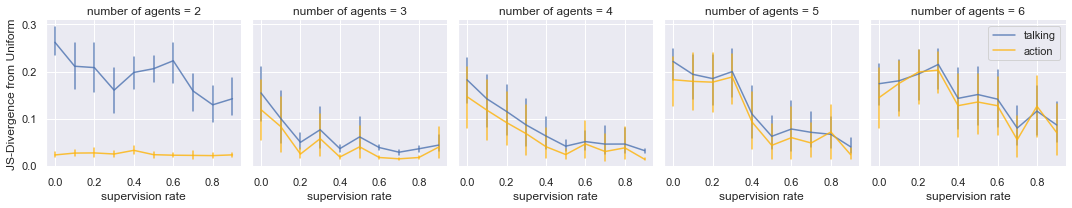

In [50]:
ax = sns.FacetGrid(df_3, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars", alpha=0.8, label = "talking")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars",  color=sns.xkcd_rgb["amber"], alpha=0.8, label = "action")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS-Divergence from Uniform')
plt.legend()


Many agents second dataset

In [17]:
cond_list_4 = [[],[]]
#lrates = [0.00001,0.0001,0.001,0.01,0.1]
punishment_weights = [3]
beta = [0.3]
memory_replay = [[10],[10]]
inner_speech_conditions = [0,1]
num_agents = [2,3,4,5,6]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 10
#for lr in lrates:
#for inn in inner_speech_conditions:
for superv in supervision:
    for n in num_agents:
        for j in range(samples):
            cond_list_4[0].append(superv)
            cond_list_4[1].append(n)

In [18]:
dirs = os.listdir("lang_games_supervision_many_agents_2/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game38.pkl',
 'game39.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'game67.pkl',
 'game68.pkl',
 'game69.pkl',
 'game70.pkl',
 'game71.pkl',
 'game72.pkl',
 'game73.pkl',
 'game74.pkl',
 'game75.pkl',
 'game76.pkl',
 'gam

In [19]:
games_4 = []
i = 0
for file in dirs:
    if i!=241: # broken file
        with open("lang_games_supervision_many_agents_2/{}".format(file), "rb") as f:
        
            g = pickle.load(f)
            games_4.append(g)
        i+=1
    else:
        pass
        i+=1

In [20]:
# one game is missing
cond_list_4[0].pop(241)
cond_list_4[1].pop(241)

6

Calculating mean scores

In [21]:
mean_scores_4 = []
for i in range(len(cond_list_4[0])):
    means = []
    for n in range(cond_list_4[1][i]): # for each agent in the game
        means.append(np.mean(games_4[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_4.append(avg)

Calculating 

1) speaker and listener consistencies

2) action and talk KL-Divergence from Uniform distribution

3) divergence of agents' talk distributions

In [22]:
sc_list4, lc_list4 = sl_consistencies(games_4, cond_list_4[1], 4000, False)
ac_div4, talk_div4 = action_talk_js_uniform(games_4, cond_list_4[1], 4000)
td4 = talk_divergence(games_4, cond_list_4[1], 4000)

In [23]:
games_4_copy = copy.deepcopy(games_4)
div_list_4 = meaning_asymmetry(games_4_copy, cond_list_4[1], 4000)
games_4_copy = copy.deepcopy(games_4)
mean_map_4 = meaning_mapping(games_4_copy, cond_list_4[1], 4000)

NameError: name 'cond_list_3' is not defined

In [25]:
data_4 = {"supervision rate": cond_list_4[0], "number of agents": cond_list_4[1], "score": mean_scores_4, 
         "speaker consistency": sc_list4, "listener consistency": lc_list4, 
         "action divergence from uniform": ac_div4, "talking divergence from uniform": ac_div4,
         "talking divergence": td4, "meaning divergence": div_list_4, "meaning mapping": mean_map_4}
df_4 = pd.DataFrame(data_4) 
df_4

,supervision rate,number of agents,score,speaker consistency,listener consistency,action divergence from uniform,talking divergence from uniform,talking divergence,meaning divergence,meaning mapping
0,0.0,2,0.514130,0.666160,0.646455,0.022709,0.022709,0.413650,0.510772,0.051388
1,0.0,2,0.573510,0.697218,0.683438,0.035993,0.035993,0.259900,0.547024,0.038288
2,0.0,2,0.503180,0.745341,0.697374,0.018784,0.018784,0.376051,0.670740,0.021620
3,0.0,2,0.494010,0.735202,0.686083,0.024021,0.024021,0.401041,0.634700,0.046348
4,0.0,2,0.460980,0.749320,0.729380,0.028979,0.028979,0.042525,0.732636,0.016449
...,...,...,...,...,...,...,...,...,...,...
494,0.9,6,0.689610,0.624462,0.618464,0.023186,0.023186,0.040800,0.035820,0.024661
495,0.9,6,0.654487,0.551796,0.531197,0.106399,0.106399,0.099408,0.071218,0.035183
496,0.9,6,0.480137,0.602321,0.566190,0.238310,0.238310,0.029469,0.094268,0.091092
497,0.9,6,0.694557,0.612676,0.580148,0.028773,0.028773,0.123219,0.056563,0.025658


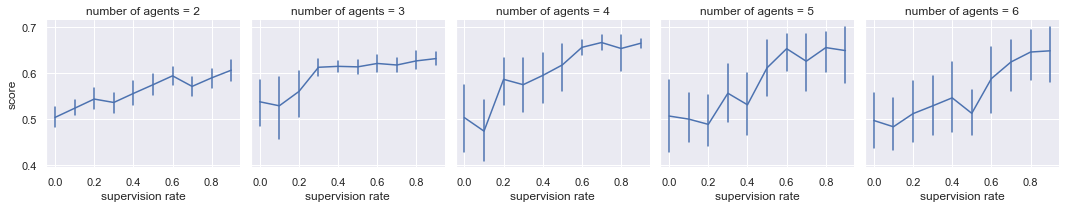

In [26]:
ax = sns.FacetGrid(df_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "score", 
                  err_style="bars")
ax.add_legend()

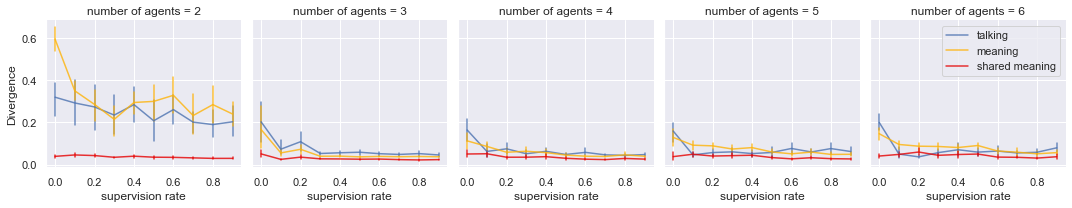

In [27]:
ax = sns.FacetGrid(df_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars", alpha=0.8, label = "talking")
ax.map(sns.lineplot,"supervision rate", "meaning divergence", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["amber"], label = "meaning")
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["red"], label = "shared meaning")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Divergence')
plt.legend()

#ax.add_legend()

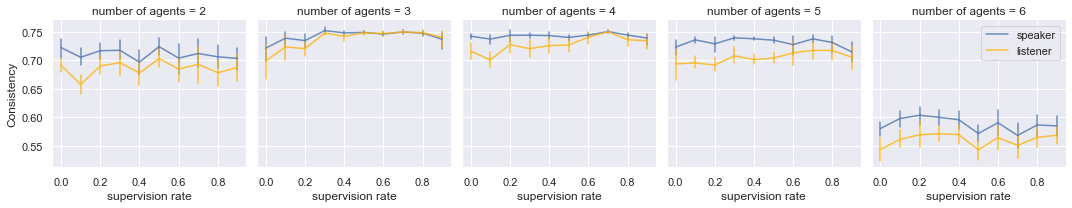

In [28]:
ax = sns.FacetGrid(df_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha=0.8, label = "speaker")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["amber"], label = "listener")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

#ax.add_legend()

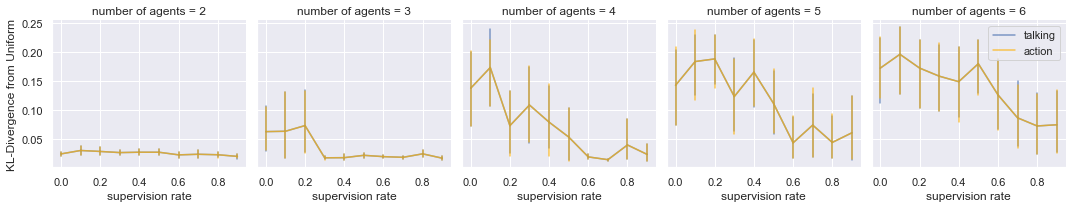

In [29]:
ax = sns.FacetGrid(df_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars", alpha=0.7, label = "talking")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars",  color=sns.xkcd_rgb["amber"], alpha=0.7, label = "action")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('KL-Divergence from Uniform')
plt.legend()

### Plots for both datasets

In [51]:
df_3_4 = pd.concat([df_3,df_4])

In [52]:
df_3_4

,supervision rate,number of agents,score,speaker consistency,listener consistency,action divergence from uniform,talking divergence from uniform,talking divergence,meaning divergence,meaning mapping
0,0.0,2,0.526180,0.711247,0.701820,0.031705,0.236156,0.342381,0.345695,0.053234
1,0.0,2,0.520420,0.746653,0.664827,0.023181,0.276594,0.233890,0.429343,0.067986
2,0.0,2,0.482460,0.698616,0.619424,0.016288,0.353482,0.426178,0.462504,0.070301
3,0.0,2,0.479820,0.729274,0.689660,0.038856,0.216636,0.411566,0.664244,0.026507
4,0.0,2,0.525730,0.719464,0.652845,0.014453,0.349242,0.653565,0.538323,0.064050
...,...,...,...,...,...,...,...,...,...,...
494,0.9,6,0.689610,0.624462,0.618464,0.023186,0.023186,0.040800,0.035820,0.024661
495,0.9,6,0.654487,0.551796,0.531197,0.106399,0.106399,0.099408,0.071218,0.035183
496,0.9,6,0.480137,0.602321,0.566190,0.238310,0.238310,0.029469,0.094268,0.091092
497,0.9,6,0.694557,0.612676,0.580148,0.028773,0.028773,0.123219,0.056563,0.025658


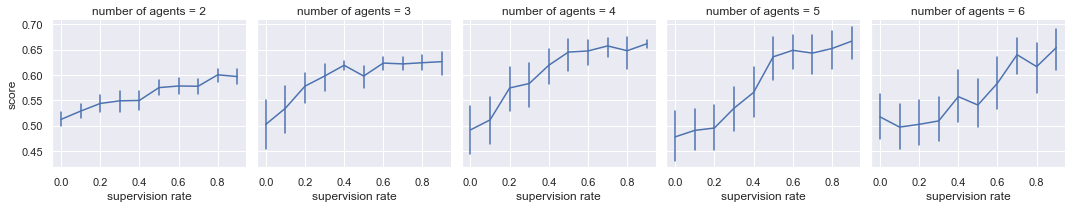

In [59]:
ax = sns.FacetGrid(df_3_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "score", 
                  err_style="bars")
ax.add_legend()

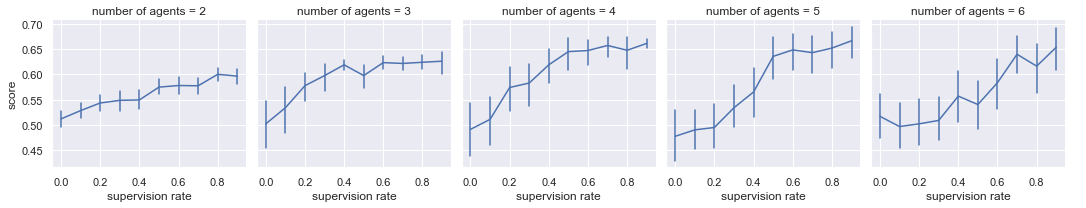

In [66]:
ax = sns.FacetGrid(df_3_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "score", 
                  err_style="bars")
ax.add_legend()

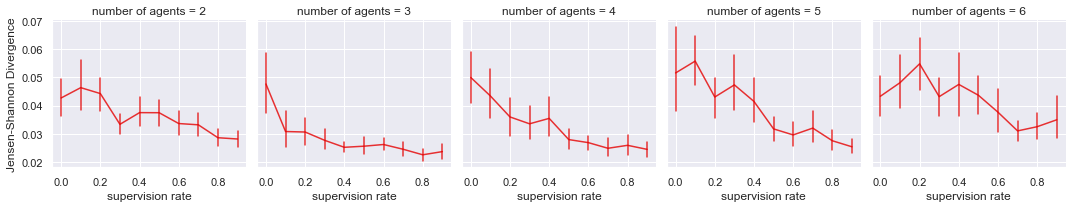

In [69]:
ax = sns.FacetGrid(df_3_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "meaning mapping", 
                  err_style="bars", alpha=0.8, color=sns.xkcd_rgb["red"], label = "signal-action mapping")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Jensen-Shannon Divergence')
#plt.legend()


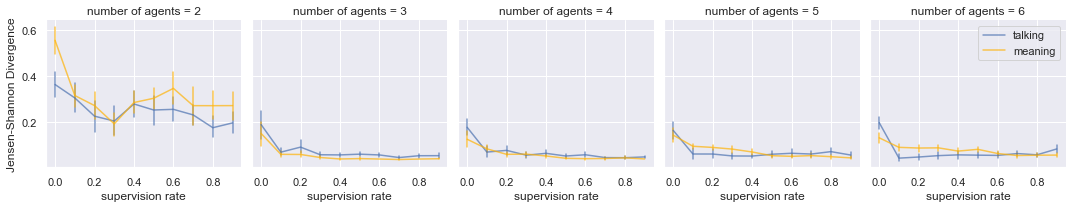

In [71]:
ax = sns.FacetGrid(df_3_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars", alpha=0.7, label = "talking")
ax.map(sns.lineplot,"supervision rate", "meaning divergence", 
                  err_style="bars", alpha=0.7, color=sns.xkcd_rgb["amber"], label = "meaning")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Jensen-Shannon Divergence')
plt.legend()

#ax.add_legend()

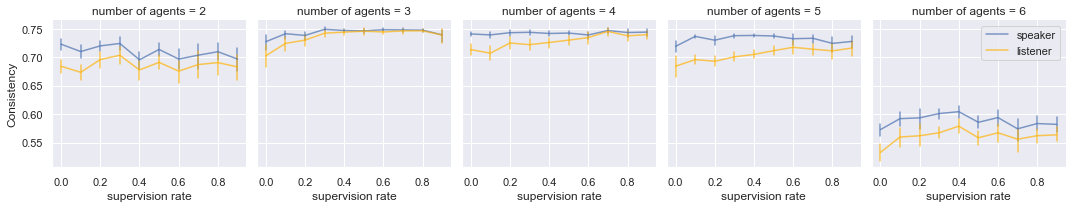

In [72]:
ax = sns.FacetGrid(df_3_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha=0.7, label = "speaker")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", alpha=0.7, color=sns.xkcd_rgb["amber"], label = "listener")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

#ax.add_legend()

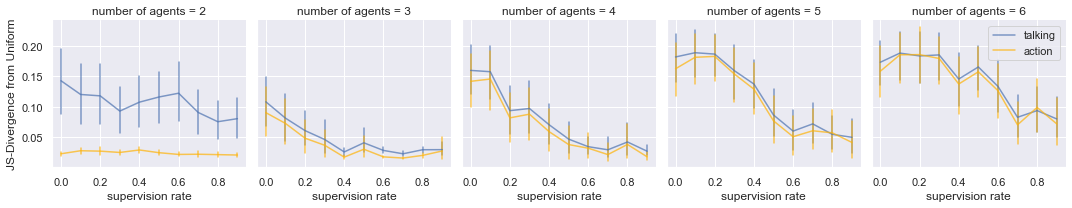

In [73]:
ax = sns.FacetGrid(df_3_4, col="number of agents")
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars", alpha=0.7, label = "talking")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars",  color=sns.xkcd_rgb["amber"], alpha=0.7, label = "action")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('JS-Divergence from Uniform')
plt.legend()

## Many agents, different vocabulary sizes

In [11]:
cond_list_5 = [[],[],[]]
#lrates = [0.00001,0.0001,0.001,0.01,0.1]
punishment_weights = [3]
beta = [0.3]
memory_replay = [[10],[10]]
inner_speech_conditions = [0,1]
num_agents = [2,4,6]
num_ent = [4,5,6,7,8]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 5
#for lr in lrates:
#for inn in inner_speech_conditions:
for superv in supervision:
    for n in num_agents:
        for v in num_ent:
            for j in range(samples):
                cond_list_5[0].append(superv)
                cond_list_5[1].append(n)
                cond_list_5[2].append(v)

In [12]:
dirs = os.listdir("lang_games_many_agents_dif_voc/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game38.pkl',
 'game39.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game50.pkl',
 'game51.pkl',
 'game52.pkl',
 'game53.pkl',
 'game54.pkl',
 'game55.pkl',
 'game56.pkl',
 'game57.pkl',
 'game58.pkl',
 'game59.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'gam

In [13]:
games_5 = []
i = 0
for file in dirs:
    print(i)
    if i!=294: # broken file

        with open("lang_games_many_agents_dif_voc/{}".format(file), "rb") as f:
            g = pickle.load(f)
            games_5.append(g)   
        i+=1
    else:
        pass
        i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
# one game is missing
cond_list_5[0].pop(294)
cond_list_5[1].pop(294)
cond_list_5[2].pop(294)

7

Calculating mean scores

In [15]:
mean_scores_5 = []
for i in range(len(cond_list_5[0])):
    means = []
    for n in range(cond_list_5[1][i]): # for each agent in the game
        means.append(np.mean(games_5[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_5.append(avg)

In [16]:
sc_list5, lc_list5 = sl_consistencies(games_5, cond_list_5[1], 4000, False)

ValueError: qk and pk must have same length.

In [21]:
ac_div5, talk_div5 = action_talk_kl_uniform(games_5, cond_list_5[1], 4000, cond_list_5[2])
td5 = talk_divergence(games_5, cond_list_5[1], 4000)

In [24]:
data_5 = {"supervision rate": cond_list_5[0], "number of agents": cond_list_5[1], 
          "vocabulary size": cond_list_5[2], "score": mean_scores_5, 
         "speaker consistency": sc_list5, "listener consistency": lc_list5, 
         "action divergence from uniform": ac_div5, "talking divergence from uniform": ac_div5,
         "talking divergence": td5}
df_5 = pd.DataFrame(data_5) 
df_5

,supervision rate,number of agents,vocabulary size,score,speaker consistency,listener consistency,action divergence from uniform,talking divergence from uniform,talking divergence
0,0.0,2,4,0.574107,0.755886,0.736859,0.002155,0.002155,0.061780
1,0.0,2,4,0.628273,0.688889,0.686007,0.000864,0.000864,0.196981
2,0.0,2,4,0.594917,0.726534,0.700164,0.004702,0.004702,0.550178
3,0.0,2,4,0.615710,0.731681,0.698148,0.001792,0.001792,0.008322
4,0.0,2,4,0.615947,0.739338,0.706831,0.000648,0.000648,0.326788
...,...,...,...,...,...,...,...,...,...
744,0.9,6,8,0.537424,0.549543,0.514095,0.327680,0.327680,0.014077
745,0.9,6,8,0.381663,0.405513,0.382202,0.483027,0.483027,0.008318
746,0.9,6,8,0.485106,0.491820,0.470347,0.343856,0.343856,0.075327
747,0.9,6,8,0.423521,0.535827,0.494616,0.383875,0.383875,0.030685


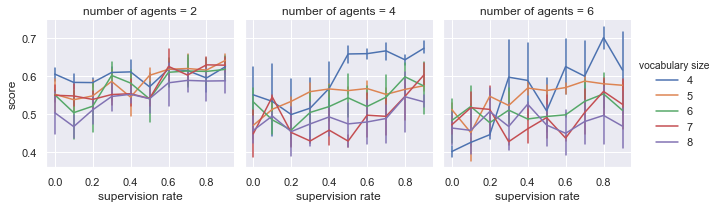

In [25]:
ax = sns.FacetGrid(df_5, col="number of agents", hue="vocabulary size")
ax.map(sns.lineplot,"supervision rate", "score", 
                  err_style="bars")
ax.add_legend()

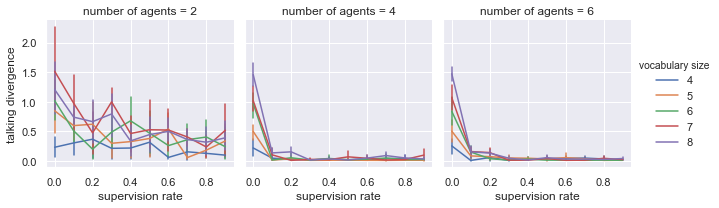

In [26]:
ax = sns.FacetGrid(df_5, col="number of agents", hue="vocabulary size")
ax.map(sns.lineplot,"supervision rate", "talking divergence", 
                  err_style="bars")
ax.add_legend()

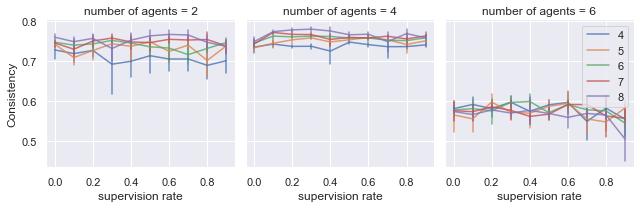

In [27]:
ax = sns.FacetGrid(df_5, col="number of agents", hue="vocabulary size")
ax.map(sns.lineplot,"supervision rate", "speaker consistency", 
                  err_style="bars", alpha=0.8)
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()
#ax.add_legend()

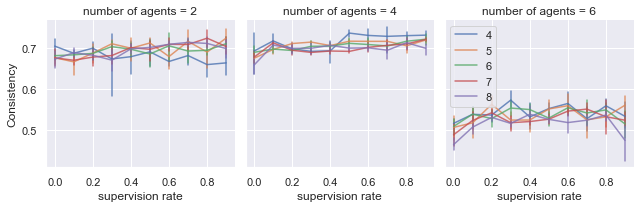

In [28]:
ax = sns.FacetGrid(df_5, col="number of agents", hue="vocabulary size")
ax.map(sns.lineplot,"supervision rate", "listener consistency", 
                  err_style="bars", alpha=0.8)
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('Consistency')
plt.legend()

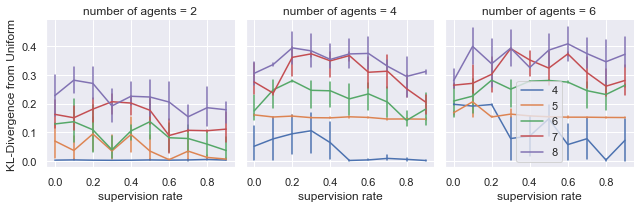

In [29]:
ax = sns.FacetGrid(df_5, col="number of agents", hue="vocabulary size")
ax.map(sns.lineplot,"supervision rate", "talking divergence from uniform", 
                  err_style="bars")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('KL-Divergence from Uniform')
plt.legend()

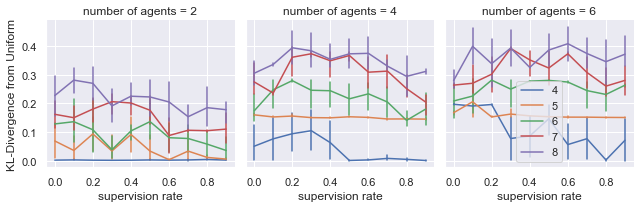

In [30]:
ax = sns.FacetGrid(df_5, col="number of agents", hue="vocabulary size")
ax.map(sns.lineplot,"supervision rate", "action divergence from uniform", 
                  err_style="bars")
for axx in ax.axes.flat:
    # This only works for the left ylabels
    axx.set_ylabel('KL-Divergence from Uniform')
plt.legend()


# Different vocabularies 2

In [31]:
cond_list_6 = [[],[],[]]
#lrates = [0.00001,0.0001,0.001,0.01,0.1]
punishment_weights = [3]
beta = [0.3]
memory_replay = [[10],[10]]
inner_speech_conditions = [0,1]
num_agents = [2,4,6]
num_ent = [4,5,6,7,8]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 5
#for lr in lrates:
#for inn in inner_speech_conditions:
for superv in supervision:
    for n in num_agents:
        for v in num_ent:
            for j in range(samples):
                cond_list_6[0].append(superv)
                cond_list_6[1].append(n)
                cond_list_6[2].append(v)

In [23]:
dirs = os.listdir("lang_games_many_agents_dif_voc_small_act_punishment/")
dirs = sorted(dirs[:], key=lambda game: int(game[4:].split(".")[0]))
dirs

['game0.pkl',
 'game1.pkl',
 'game2.pkl',
 'game3.pkl',
 'game4.pkl',
 'game5.pkl',
 'game6.pkl',
 'game7.pkl',
 'game8.pkl',
 'game9.pkl',
 'game10.pkl',
 'game11.pkl',
 'game12.pkl',
 'game13.pkl',
 'game14.pkl',
 'game15.pkl',
 'game16.pkl',
 'game17.pkl',
 'game18.pkl',
 'game19.pkl',
 'game20.pkl',
 'game21.pkl',
 'game22.pkl',
 'game23.pkl',
 'game24.pkl',
 'game25.pkl',
 'game26.pkl',
 'game27.pkl',
 'game28.pkl',
 'game29.pkl',
 'game30.pkl',
 'game31.pkl',
 'game32.pkl',
 'game33.pkl',
 'game34.pkl',
 'game35.pkl',
 'game36.pkl',
 'game37.pkl',
 'game38.pkl',
 'game39.pkl',
 'game40.pkl',
 'game41.pkl',
 'game42.pkl',
 'game43.pkl',
 'game44.pkl',
 'game45.pkl',
 'game46.pkl',
 'game47.pkl',
 'game48.pkl',
 'game49.pkl',
 'game50.pkl',
 'game51.pkl',
 'game52.pkl',
 'game53.pkl',
 'game54.pkl',
 'game55.pkl',
 'game56.pkl',
 'game57.pkl',
 'game58.pkl',
 'game59.pkl',
 'game60.pkl',
 'game61.pkl',
 'game62.pkl',
 'game63.pkl',
 'game64.pkl',
 'game65.pkl',
 'game66.pkl',
 'gam

In [29]:
games_6 = []
i = 0
for file in dirs:
    print(i)
    if i not in [56,276, 443, 507]: # broken file

        with open("lang_games_many_agents_dif_voc_small_act_punishment/{}".format(file), "rb") as f:
            g = pickle.load(f)
            games_6.append(g)   
        i+=1
    else:
        pass
        i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
cond_list_6[0].pop(56)
cond_list_6[1].pop(56)
cond_list_6[2].pop(56)
cond_list_6[0].pop(276)
cond_list_6[1].pop(276)
cond_list_6[2].pop(276)
cond_list_6[0].pop(443)
cond_list_6[1].pop(443)
cond_list_6[2].pop(443)
cond_list_6[0].pop(507)
cond_list_6[1].pop(507)
cond_list_6[2].pop(507)

6

In [33]:
mean_scores_6 = []
for i in range(len(cond_list_6[0])):
    means = []
    for n in range(cond_list_6[1][i]): # for each agent in the game
        means.append(np.mean(games_6[i][2][n][-2000:]))
    avg = np.mean(means)
    mean_scores_6.append(avg)

In [34]:
data_6 = {"supervision_rate": cond_list_6[0], "num_of_agents": cond_list_6[1], "vocabulary_size": cond_list_6[2], "score": mean_scores_6}
df_6 = pd.DataFrame(data_6) 
df_6

,supervision_rate,num_of_agents,vocabulary_size,score
0,0.0,2,4,0.684560
1,0.0,2,4,0.531883
2,0.0,2,4,0.701594
3,0.0,2,4,0.656060
4,0.0,2,4,0.677633
...,...,...,...,...
741,0.9,6,8,0.553126
742,0.9,6,8,0.513405
743,0.9,6,8,0.563935
744,0.9,6,8,0.655729


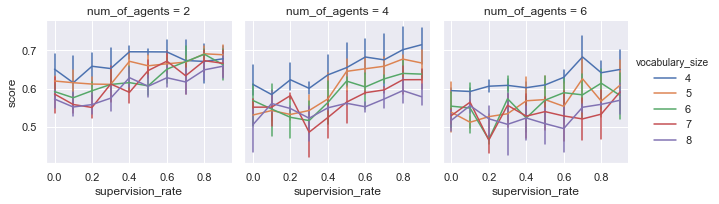

In [35]:
ax = sns.FacetGrid(df_6, col="num_of_agents", hue="vocabulary_size")
ax.map(sns.lineplot,"supervision_rate", "score", 
                  err_style="bars")
ax.add_legend()

In [36]:
cond_list = []
#lrates = [0.00001,0.0001,0.001,0.01,0.1]
punishment_weights = [3]
beta = [0.3]
memory_replay = [[10],[10]]
inner_speech_conditions = [0,1]
num_agents = [2,3,4,5,6,10]
supervision = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
samples = 20
#for lr in lrates:
#for inn in inner_speech_conditions:
for superv in supervision:
    for inn in inner_speech_conditions:
        for j in range(samples):
            cond_list.append([superv, inn])

In [42]:
cond_list[370]

[0.9, 0]